# Import modules

Firstly, let's import the modules that we will use in this example

In [1]:
import xarray as xr # For creating a NetCDF dataset
import pandas as pd # For reading in data (CSV, xlsx etc) to a dataframe
from datetime import datetime as dt # Handling dates and times
import uuid # Creating a UUID for the dataset

# Loading and checking the data

Let's look at the data we are working with first. Here, we are working with a time series of meteorological measurements from a temporary weather station set up on the sea ice. Here, we are assuming the same latitude and longitude for all points in time. This is not real data, but values I made up. I have no idea if they are realistic, but you should get the idea!

In [2]:
data = pd.read_excel('meteorological_measurements_time_series_variables.xlsx', sheet_name='Data')
data

,Time,air_temperature (degC),wind_speed (m s-1),relative_humidity (%)
0,10:00:00,-13.4,3.4,45
1,11:00:00,-13.1,3.6,47
2,12:00:00,-12.9,3.2,48
3,13:00:00,-12.8,3.7,47
4,14:00:00,-12.7,3.8,48
5,15:00:00,-12.8,3.9,50
6,16:00:00,-12.4,4.1,51
7,17:00:00,-12.3,4.5,52
8,18:00:00,-12.4,5.2,54
9,19:00:00,-12.1,6.1,55


<AxesSubplot:xlabel='Time'>

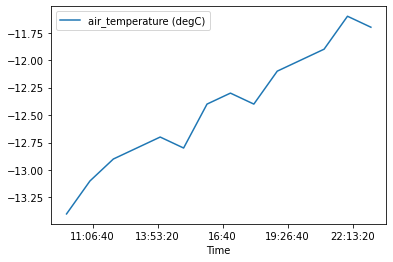

In [3]:
data.plot(x='Time', y=['air_temperature (degC)'])

<AxesSubplot:xlabel='Time'>

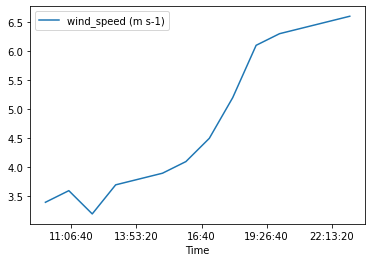

In [4]:
data.plot(x='Time', y=['wind_speed (m s-1)'])

<AxesSubplot:xlabel='Time'>

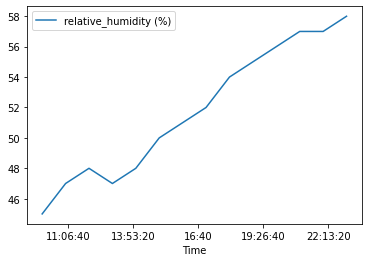

In [5]:
data.plot(x='Time', y=['relative_humidity (%)'])

# Converting units and standard names for variables

Each variable should have a standard name. Standard names are commonly used and accepted parameter names with descriptions. By selecting appropriate standard names for your variable, the data user will be clear exactly what the data represent. The standard_name should be selected from here: http://cfconventions.org/standard-names.html

The units should match what is provided for the standard name as listed above. In this case, the air temperature needs to be converted to kelvin. We can also change the names of our other variables to conform with standard names. This isn't strictly neccessary, but I think it is neater. 

In [6]:
data['air_temperature'] = data['air_temperature (degC)'] + 273.15
data['relative_humidity'] = data['relative_humidity (%)']
data['wind_speed'] = data['wind_speed (m s-1)']

# Dimensions: About time

This dataset will have a single dimension, time. There are specific recommendations on how time should be stored in netCDF files. I will try to explain briefly here, and there is a nice explanation here too: https://www.unidata.ucar.edu/software/netcdf/time/recs.html

It is most common to have a dimension named "time" as well as a coordinate variable with the same name. Let's discuss the variable first.

The "time" variable has units that count from a user defined origin, for example "hours since 2020-01-01 00:00 UTC" or "days since 2014-01-01". The units may be in years, days, seconds, nanoseconds, etc. Whilst this approach may seem strange at a glance, it allows the times to be stored in conventional numerical formats such as integers, and to our desired precision. This is much more efficient than using a long datetime string for each coordinate. 

And what about the time dimension? Well this defines the *shape* or *grid* of the data. In this dataset, we will have 4 variables (time, air_temperature, relative_humidity, wind_speed), and they will all have the same dimension "time". Therefore, the dimension helps the data user to link each of the variables together. 

So let's create a new time column in our pandas dataframe that meets these requirements. How you do this will depend on how your dates or times are stored.

In [7]:
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S') # Convert to datetime values that I can easily work with
data['hour'] = data['Time'].dt.hour # Get hour only as integers

# Creating an xarray dataset

With xarray, it is easy to create an xarray dataset and convert it to a NetCDF dataset.

We can write the variables that vary within a single dataset to an xarray dataset.

In [8]:
# Note the double square brackets
xrds = xr.Dataset.from_dataframe(data[['hour','air_temperature','relative_humidity', 'wind_speed']]) 

A NetCDF file has dimensions that define the shape of the data. In this case, our only dimension is "time". The name "time" all in lower case is CF compliant.

In [9]:
xrds = xrds.rename_dims({'index':'time'}) # Renaming dimension to time, compliant with CF conventions

xrds = xrds.rename({'hour':'time'}) # Renaming variable to time, to match dimension and compliant with CF conventions

xrds = xrds.set_coords('time') # Specfiy time as a coordinate (to be used as a dimension)
        
xrds = xrds.reset_index('index', drop=True) # Get rid of the numeric index as dimension and coordinate variable.

# Global attributes

Global attributes describe the dataset as a whole. A list of what global attributes must be included can be found here:

https://adc.met.no/node/4

These are based on the ACDD conventions, that you can find here:

https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3

We refer to which conventions the file adheres to (including version) in the 'conventions' global attribute.

Additional global attributes can also be included, defined by the user. Make sure that the attribute names you select are understandable.

To save you from having to write them all out, I have written them in a separate file that you can load in as below.

In [10]:
global_attributes = pd.read_excel('meteorological_measurements_time_series_global_attributes.xlsx', index_col=0)

global_attributes

,Content
Attribute name,
title,"Meteorological measurements from 78.4365 °N, 7..."
naming_authority,University Centre in Svalbard (UNIS)
id,1b8a577c-9601-5056-9b81-9e7b802da117
summary,ANALAGOUS TO AN ABSTRACT IN A PAPER
keywords,Earth Science > Atmosphere > Atmospheric Winds...
keywords_vocabulary,GCMD
geospatial_lat_min,78.4365
geospatial_lat_max,78.4365
geospatial_lon_min,31.0124


Let's flip the columns and rows the other way round

In [11]:
global_attributes_transposed = global_attributes.transpose()
global_attributes_transposed

Attribute name,title,naming_authority,id,summary,keywords,keywords_vocabulary,geospatial_lat_min,geospatial_lat_max,geospatial_lon_min,geospatial_lon_max,...,creator_url,creator_name,publisher_name,publisher_url,publisher_email,publisher_type,project,license,metadata_link,acknowledgements
Content,"Meteorological measurements from 78.4365 °N, 7...",University Centre in Svalbard (UNIS),1b8a577c-9601-5056-9b81-9e7b802da117,ANALAGOUS TO AN ABSTRACT IN A PAPER,Earth Science > Atmosphere > Atmospheric Winds...,GCMD,78.4365,78.4365,31.0124,31.0124,...,https://www.unis.no/staff/ola-nordmann/,Ola Nordmann,NIRD Research Data Archive,https://archive.norstore.no/,archive.manager@norstore.no,institution,The Nansen Legacy (RCN # 276730),https://creativecommons.org/licenses/by/4.0/,DOI PROVIDED BY DATA CENTRE – THAT LINKS TO TH...,Funded by the Research Council of Norway. John...


Now we can convert our dataframe to a dictionary that we can easily write to the xarray dataset (that will become our NetCDF file)

In [12]:
global_attributes_dic = global_attributes_transposed.to_dict('records')[0]
xrds.attrs=global_attributes_dic
xrds.attrs

{'title': 'Meteorological measurements from 78.4365 °N, 78.4365 °E the the Northern Barents Sea, 2021-02-21',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': '1b8a577c-9601-5056-9b81-9e7b802da117',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Earth Science > Atmosphere > Atmospheric Winds > Surface Winds > Wind Speed; Earth Science > Atmosphere > Atmospheric Water Vapor > Water Vapor Indicators > Relative Humidity; Earth Science > Atmosphere > Atmospheric Winds > Surface temperature > Air Temperature',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 78.4365,
 'geospatial_lat_max': 78.4365,
 'geospatial_lon_min': 31.0124,
 'geospatial_lon_max': 31.0124,
 'time_coverage_start': '2021-02-21T10:00:00Z',
 'time_coverage_end': '2021-02-21T23:00:00Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File created using Python’s xarray at INSERT TIMESTAMP HERE',
 'source': 'Meteorological measurements from temporary station deployed on the sea ice'

Now let's update some of the attributes to include the current timestamp where needed

In [13]:
xrds.attrs['date_created'] = dt.now().strftime("%Y-%m-%dT%H:%M:%SZ")
xrds.attrs['history'] = f'File create at {dt.now().strftime("%Y-%m-%dT%H:%M:%SZ")} using xarray in Python'
xrds.attrs

{'title': 'Meteorological measurements from 78.4365 °N, 78.4365 °E the the Northern Barents Sea, 2021-02-21',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': '1b8a577c-9601-5056-9b81-9e7b802da117',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Earth Science > Atmosphere > Atmospheric Winds > Surface Winds > Wind Speed; Earth Science > Atmosphere > Atmospheric Water Vapor > Water Vapor Indicators > Relative Humidity; Earth Science > Atmosphere > Atmospheric Winds > Surface temperature > Air Temperature',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 78.4365,
 'geospatial_lat_max': 78.4365,
 'geospatial_lon_min': 31.0124,
 'geospatial_lon_max': 31.0124,
 'time_coverage_start': '2021-02-21T10:00:00Z',
 'time_coverage_end': '2021-02-21T23:00:00Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File create at 2022-01-28T09:37:30Z using xarray in Python',
 'source': 'Meteorological measurements from temporary station deployed on the sea ice',

# Variable attributes

Variable attributes describe each variable. Let's add some attributes for our variables.

The *standard_name* should be selected from here: http://cfconventions.org/standard-names.html. Standard names are commonly accepted parameter names with descriptions. By selecting appropriate standard names for your variable, the data user will be clear exactly what the data represent.

The *units* should match what is provided for the standard name as listed above. You may need to convert your data.

The *long_name* is more descriptive and can be in your own words.

The *coverage_content_type* describes what type of data the variable contains

Some help on these variable attributes can be found here: https://commons.esipfed.org/acdd_1-3_references

In [14]:
xrds['time'].attrs = {
'standard_name': 'time',
'long_name':'time',
'units': 'hours since 2021-02-21T00:00:00Z'
}

xrds['air_temperature'].attrs = {
'standard_name':'air_temperature',
'long_name':'Air temperature in degrees kelvin, measured at an elevation of 2 meters',
'units': 'K',
'coverage_content_type': 'physicalMeasurement'
}

xrds['relative_humidity'].attrs = {
'standard_name':'relative_humidity',
'long_name':'Relative humidity of air, the amount of moisture in the air at a certain temperature compared to what the air can "hold" at that temperature',
'units': '1',
'coverage_content_type': 'physicalMeasurement'
}

xrds['wind_speed'].attrs = {
'standard_name':'wind_speed',
'long_name':'Wind speed, magnitude of the 2 horizontal components of velocity, measured at an elevation of 2 meters',
'units': 'ms-1',
'coverage_content_type': 'physicalMeasurement'
}


Ensure that data are written in the correct form to NetCDF. 
Data served through THREDDS Data Servers cannot have int64 datetime 
specifications, but int32. Also, encoding of missing values are done 
in this step along compression.

# Converting to NetCDF-CF

First, we specify the encoding, then we conver the data to a NetCDF file.

In [15]:
myencoding = {
            'time': {
                'dtype': 'int32',
                '_FillValue': None # Coordinate variables should not have fill values.
            },
            'air_temperature': {
                '_FillValue': -999.0,
                'zlib': False
            },
            'wind_speed': {
                '_FillValue': 3.5e8,
                'zlib': False
            },
            'relative_humidity': {
                '_FillValue': 3.5e8,
                'zlib': False
            }
        }
        
xrds.to_netcdf('meteorological_measurements_time_series.nc',encoding=myencoding)

And that is it! 

# QC the dataset

Now we can check that the file is okay by loading it in again.

In [16]:
myfile = xr.load_dataset('meteorological_measurements_time_series.nc')

In [17]:
myfile

<xarray.Dataset>
Dimensions:            (time: 14)
Coordinates:
  * time               (time) datetime64[ns] 2021-02-21T10:00:00 ... 2021-02-...
Data variables:
    air_temperature    (time) float64 259.8 260.0 260.2 ... 261.2 261.5 261.4
    relative_humidity  (time) float64 45.0 47.0 48.0 47.0 ... 57.0 57.0 58.0
    wind_speed         (time) float64 3.4 3.6 3.2 3.7 3.8 ... 6.3 6.4 6.5 6.6
Attributes: (12/30)
    title:                Meteorological measurements from 78.4365 °N, 78.436...
    naming_authority:     University Centre in Svalbard (UNIS)
    id:                   1b8a577c-9601-5056-9b81-9e7b802da117
    summary:              ANALAGOUS TO AN ABSTRACT IN A PAPER
    keywords:             Earth Science > Atmosphere > Atmospheric Winds > Su...
    keywords_vocabulary:  GCMD
    ...                   ...
    publisher_email:      archive.manager@norstore.no
    publisher_type:       institution
    project:              The Nansen Legacy (RCN # 276730)
    license:              https://creativecommons.org/licenses/by/4.0/
    metadata_link:        DOI PROVIDED BY DATA CENTRE – THAT LINKS TO THE LAN...
    acknowledgements:     Funded by the Research Council of Norway. John Doe ...

In [18]:
myfile.attrs

{'title': 'Meteorological measurements from 78.4365 °N, 78.4365 °E the the Northern Barents Sea, 2021-02-21',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'id': '1b8a577c-9601-5056-9b81-9e7b802da117',
 'summary': 'ANALAGOUS TO AN ABSTRACT IN A PAPER',
 'keywords': 'Earth Science > Atmosphere > Atmospheric Winds > Surface Winds > Wind Speed; Earth Science > Atmosphere > Atmospheric Water Vapor > Water Vapor Indicators > Relative Humidity; Earth Science > Atmosphere > Atmospheric Winds > Surface temperature > Air Temperature',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 78.4365,
 'geospatial_lat_max': 78.4365,
 'geospatial_lon_min': 31.0124,
 'geospatial_lon_max': 31.0124,
 'time_coverage_start': '2021-02-21T10:00:00Z',
 'time_coverage_end': '2021-02-21T23:00:00Z',
 'Conventions': 'ACDD-1.3; CF-1.8',
 'history': 'File create at 2022-01-28T09:37:30Z using xarray in Python',
 'source': 'Meteorological measurements from temporary station deployed on the sea ice',

In [19]:
myfile.data_vars

Data variables:
    air_temperature    (time) float64 259.8 260.0 260.2 ... 261.2 261.5 261.4
    relative_humidity  (time) float64 45.0 47.0 48.0 47.0 ... 57.0 57.0 58.0
    wind_speed         (time) float64 3.4 3.6 3.2 3.7 3.8 ... 6.3 6.4 6.5 6.6

In [20]:
myfile['time']

<xarray.DataArray 'time' (time: 14)>
array(['2021-02-21T10:00:00.000000000', '2021-02-21T11:00:00.000000000',
       '2021-02-21T12:00:00.000000000', '2021-02-21T13:00:00.000000000',
       '2021-02-21T14:00:00.000000000', '2021-02-21T15:00:00.000000000',
       '2021-02-21T16:00:00.000000000', '2021-02-21T17:00:00.000000000',
       '2021-02-21T18:00:00.000000000', '2021-02-21T19:00:00.000000000',
       '2021-02-21T20:00:00.000000000', '2021-02-21T21:00:00.000000000',
       '2021-02-21T22:00:00.000000000', '2021-02-21T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-02-21T10:00:00 ... 2021-02-21T23:00:00
Attributes:
    standard_name:  time
    long_name:      time

In [21]:
myfile['air_temperature']

<xarray.DataArray 'air_temperature' (time: 14)>
array([259.75, 260.05, 260.25, 260.35, 260.45, 260.35, 260.75, 260.85,
       260.75, 261.05, 261.15, 261.25, 261.55, 261.45])
Coordinates:
  * time     (time) datetime64[ns] 2021-02-21T10:00:00 ... 2021-02-21T23:00:00
Attributes:
    standard_name:          air_temperature
    long_name:              Air temperature in degrees kelvin, measured at an...
    units:                  K
    coverage_content_type:  physicalMeasurement

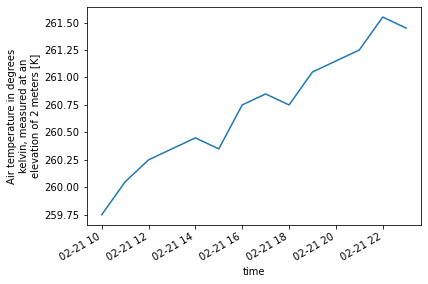

In [22]:
myfile['air_temperature'].plot.line()

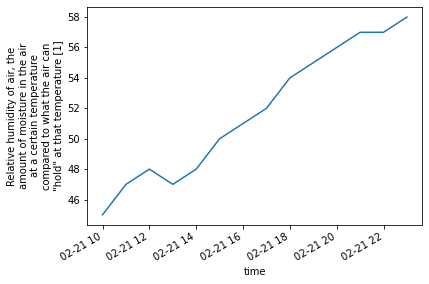

In [23]:
myfile['relative_humidity'].plot.line()

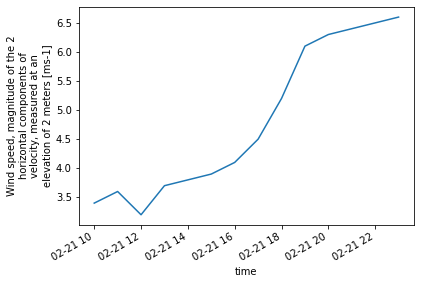

In [24]:
myfile['wind_speed'].plot.line()